In [1]:
import numpy as np
import cv2
import os
import zipfile
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Conv2DTranspose, Input, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

In [2]:
blur_dataset_path = 'blurdataset'

In [3]:
blur_dataset = os.listdir(blur_dataset_path)

In [4]:
blur_dataset

['1.jpg',
 '10.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg']

In [5]:
noisy_dataset_path = 'noisy_images'

In [6]:
noisy_dataset = os.listdir(noisy_dataset_path)

In [7]:
noisy_dataset

['0016.jpg',
 '0017.jpg',
 '0018.jpg',
 '0019.jpg',
 '1.jpg',
 '10.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '8.jpg',
 '9.jpg']

In [8]:
clean_img_path = 'clean_img'

In [9]:
clean_img_dataset = os.listdir(clean_img_path)

In [10]:
clean_img_dataset

['1.jpg',
 '10.jpg',
 '2.png',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpeg']

In [11]:
import os
from PIL import Image
import numpy as np
from skimage.transform import resize


image_height, image_width = 256, 256

blur_images = []
noisy_images = []
clean_images = []


blur_dataset_path = r'E:\Study with Python\Image processing\Version_1\blurdataset'
noisy_dataset_path = r'E:\Study with Python\Image processing\Version_1\noisy_images'
clean_img_path = r'E:\Study with Python\Image processing\Version_1\clean_img'

# Verify if the directories exist
print("Checking if directories exist:")
for path in [blur_dataset_path, noisy_dataset_path, clean_img_path]:
    if not os.path.isdir(path):
        print(f"Directory does not exist: {path}")
    else:
        print(f"Directory confirmed: {path}")

for i in range(1, 11):
    blur_image_file = f'{i}.jpg'
    noisy_image_file = f'{i}.jpg'
    clean_image_file = f'{i}.jpg'
    
    blur_image_path = os.path.join(blur_dataset_path, blur_image_file)
    noisy_image_path = os.path.join(noisy_dataset_path, noisy_image_file)
    clean_image_path = os.path.join(clean_img_path, clean_image_file)
    
 
    if os.path.exists(blur_image_path):
        blur_image = Image.open(blur_image_path).convert('RGB')
        blur_image = resize(np.array(blur_image), (image_height, image_width), anti_aliasing=True)
        blur_images.append(blur_image / 255.0) # Normalize to [0, 1]
        print(f"Loaded: {blur_image_path}")
    else:
        print(f"File not found: {blur_image_path}")
    
   
    if os.path.exists(noisy_image_path):
        noisy_image = Image.open(noisy_image_path).convert('RGB')
        noisy_image = resize(np.array(noisy_image), (image_height, image_width), anti_aliasing=True)
        noisy_images.append(noisy_image / 255.0) # Normalize to [0, 1]
        print(f"Loaded: {noisy_image_path}")
    else:
        print(f"File not found: {noisy_image_path}")
    
   
    if os.path.exists(clean_image_path):
        clean_image = Image.open(clean_image_path).convert('RGB')
        clean_image = resize(np.array(clean_image), (image_height, image_width), anti_aliasing=True)
        clean_images.append(clean_image / 255.0) # Normalize to [0, 1]
        print(f"Loaded: {clean_image_path}")
    else:
        print(f"File not found: {clean_image_path}")


blur_images_np = np.array(blur_images, dtype=np.float32)
noisy_images_np = np.array(noisy_images, dtype=np.float32)
clean_images_np = np.array(clean_images, dtype=np.float32)


print(f"Number of blur images loaded: {len(blur_images_np)}")
print(f"Number of noisy images loaded: {len(noisy_images_np)}")
print(f"Number of clean images loaded: {len(clean_images_np)}")

Checking if directories exist:
Directory confirmed: E:\Study with Python\Image processing\Version_1\blurdataset
Directory confirmed: E:\Study with Python\Image processing\Version_1\noisy_images
Directory confirmed: E:\Study with Python\Image processing\Version_1\clean_img
Loaded: E:\Study with Python\Image processing\Version_1\blurdataset\1.jpg
Loaded: E:\Study with Python\Image processing\Version_1\noisy_images\1.jpg
Loaded: E:\Study with Python\Image processing\Version_1\clean_img\1.jpg
Loaded: E:\Study with Python\Image processing\Version_1\blurdataset\2.jpg
Loaded: E:\Study with Python\Image processing\Version_1\noisy_images\2.jpg
File not found: E:\Study with Python\Image processing\Version_1\clean_img\2.jpg
Loaded: E:\Study with Python\Image processing\Version_1\blurdataset\3.jpg
Loaded: E:\Study with Python\Image processing\Version_1\noisy_images\3.jpg
Loaded: E:\Study with Python\Image processing\Version_1\clean_img\3.jpg
Loaded: E:\Study with Python\Image processing\Version_1\

In [17]:
from sklearn.model_selection import train_test_split


# Split datasets into training (60%) and temporary (40%) sets
X_train_noisy, X_temp_noisy, X_train_clean, X_temp_clean = train_test_split(
    noisy_images_np, clean_images_np, test_size=0.4, random_state=42
)

# Further split the temporary set into validation and test sets, each 20% of the original
X_val_noisy, X_test_noisy, X_val_clean, X_test_clean = train_test_split(
    X_temp_noisy, X_temp_clean, test_size=0.5, random_state=42
)


In [18]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    merge1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    merge2 = concatenate([conv1, up2], axis=3)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge2)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    # Output layer
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Print the model summary to verify the architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_11[0][0]']           
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_12[0][0]']           
 g2D)                                                                                       

In [20]:
history = model.fit(
    x=X_train_noisy, 
    y=X_train_clean,  
    validation_data=(X_val_noisy, X_val_clean),  
    epochs=20,  
    batch_size=16, 
    verbose=1  # Shows progress bar during training
)

Epoch 1/20
1/1 [==============================] - 12s 12s/step - loss: 0.2478 - accuracy: 0.2081 - val_loss: 0.2467 - val_accuracy: 0.0651
Epoch 2/20
1/1 [==============================] - 10s 10s/step - loss: 0.2466 - accuracy: 0.1979 - val_loss: 0.2430 - val_accuracy: 0.0651
Epoch 3/20
1/1 [==============================] - 9s 9s/step - loss: 0.2430 - accuracy: 0.1979 - val_loss: 0.2302 - val_accuracy: 0.0660
Epoch 4/20
1/1 [==============================] - 10s 10s/step - loss: 0.2301 - accuracy: 0.1978 - val_loss: 0.1801 - val_accuracy: 0.0682
Epoch 5/20
1/1 [==============================] - 10s 10s/step - loss: 0.1801 - accuracy: 0.1994 - val_loss: 0.0524 - val_accuracy: 0.0696
Epoch 6/20
1/1 [==============================] - 10s 10s/step - loss: 0.0523 - accuracy: 0.2003 - val_loss: 8.5404e-04 - val_accuracy: 0.0630
Epoch 7/20
1/1 [==============================] - 9s 9s/step - loss: 8.5197e-04 - accuracy: 0.1955 - val_loss: 1.6942e-05 - val_accuracy: 0.0217
Epoch 8/20
1/1 [===

In [21]:
model.save('unet_image_restoration.h5')

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_noisy, X_test_clean)

In [35]:
test_loss, test_accuracy = score

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

Test loss: 0.38, Test accuracy: 0.62


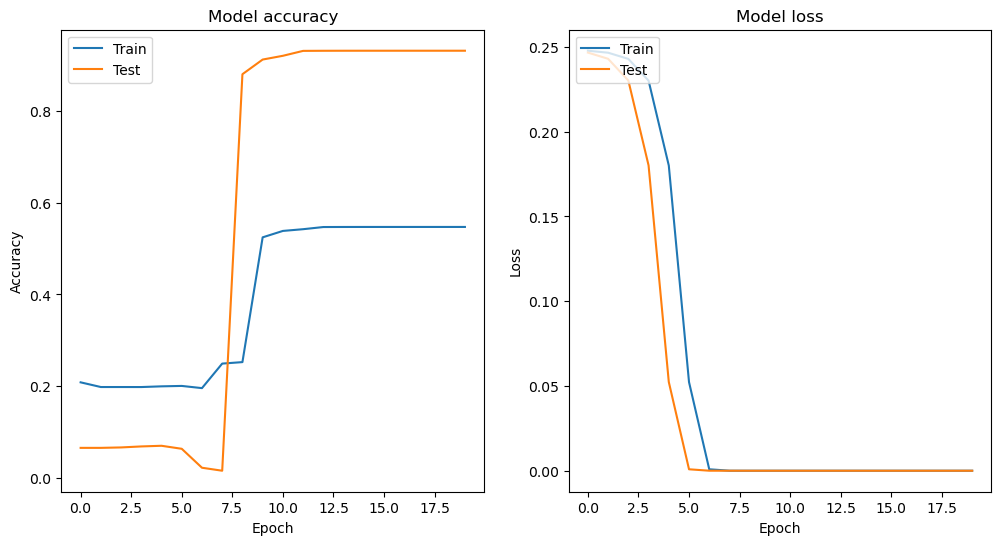

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

1/1 [==============================] - 1s 1s/step


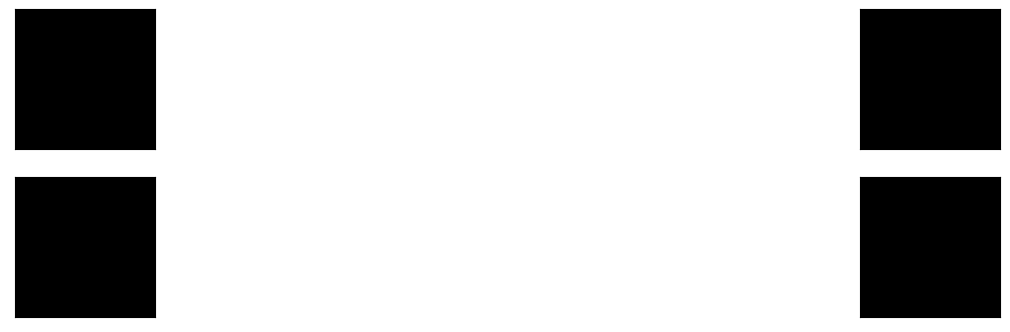

In [24]:
predicted_images = model.predict(X_test_noisy)

# Visualize the results
n = 2  # Number of images to show
plt.figure(figsize=(20, 4))
for i in range(n):
    
    # Display original noisy image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_noisy[i].reshape(256, 256, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_images[i].reshape(256, 256, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()